<a href="https://colab.research.google.com/github/awenroberts/QM2/blob/main/Copy_of_W9_Distributions_and_Basic_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Difference in Differences

## *Workshop 9*  [![Open In Colab](https://github.com/oballinger/QM2/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/oballinger/QM2/blob/main/notebooks/W08.%20Diff-in-Diff.ipynb)

### Aims:

This workshop builds on last week's material, replicating analysis in published academic research on the relationship between minimum wages and unemployment.

As always we'll start by importing the libraries I need

In [22]:
#!pip install linearmodels
import pandas as pd
import seaborn as sns
import numpy as np
import plotly
import plotly.express as px
import warnings
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import pylab


warnings.filterwarnings('ignore')
sns.set(font_scale=1.5)
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 8)

----------------------
## Panel Regression

[Surveys](https://www.pewresearch.org/politics/2012/04/17/with-voters-focused-on-economy-obama-lead-narrows/) indicate that "**jobs**" are consistently one of the most important issues among voters in U.S. presidential elections, and that **Republicans** are [typically perceived](https://thehill.com/homenews/campaign/3700047-republicans-hold-14-point-advantage-on-which-party-would-do-better-job-on-economy-poll/) as **better** in handling the economy than Democrats. An [article](https://www.nbcnews.com/news/us-news/where-did-trump-make-election-gains-unemployment-data-tells-surprising-n1247935) in NBC claims that "analysis of unemployment and voting data found that the president’s share of the vote held steady or increased in each of the 20 counties with the highest rise in unemployment from September 2019 to September 2020. And his vote share improved by 1 percentage point or more in 70 of the 100 hardest-hit counties." Let's look into this.

in 20 counties with the highest **rise in unemployment**
- votes for president held steady/ increased.

in 70/100 hardest hit counties
- votes increased by 1% or more

### Data Collection

There are only 50 states in the U.S. but there are over **3000 counties**-- this allows us to increase our sample size and perform a more fine-grained analysis. This is particularly important if we're interested in investigating the **relationship between unemployment and voting behaviour**, because of the **urban-rural divide**. For example, with in the state of New York there are probably vast differences in social and economic factors relevant to voting behaviour between Manhattan and very rural areas; this variation is lost when we look at aggregate state-level resutls, but visible when we look at the county-level. As such, in addition to the datasets we've just imported, we're going to be downloading **county-level unemployment data** straight from the BLS using the loop below.

In [37]:
counties=pd.read_csv('https://storage.googleapis.com/qm2/wk10/county_labor.csv', converters={'county_fips': str})
counties.head()

,state,county,year,unemployment,population,county_fips
0,1,1,2008,5.3,24.687,01001
1,1,3,2008,4.8,83.205,01003
2,1,5,2008,9.1,10.175,01005
3,1,7,2008,6.0,8.751,01007
4,1,9,2008,4.8,26.693,01009


Part of the cleaning process in the cell above involves the creation of a column called "county_fips"-- this stands for [Federal Information Processing System](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt#:~:text=FIPS%20codes%20are%20numbers%20which,to%20which%20the%20county%20belongs.). This is a code that uniquely identifies states and counties in the U.S. A two digit FIPS code identifies states (e.g. 01: Alabama, 02: Alaska, etc.) and a five digit fips code identifies counties (e.g. 010001: Atauga County, Alabama; 02068: Denali Borough, Alaska). Notice, the first two digits of the five-digit county FIPS code indicates the state. Boring, yes, but these codes are imperative in allowing us to join county- and state- level datasets from different sources quicky and easily. Imagine what a nightmare it would be to try to join them using the names of the counties, having to deal with capitalizations, punctuation, etc. Yikes.

### Maps

Great-- we've now got clean, **county-level unemployment and population data spanning from 1990-2022 on an annual basis**. Lets make a map to explore the spatial distribution of unemployment across time in the U.S. In order to do that, we're going to need a spatial file that tells us the shapes of the counties; I've imported it as a variable called `county_polygons`. We're then going to create an  map using the [Plotly](https://plotly.com/python/) library, which is great for making pretty, interactive maps and plots. It will have a slider on the bottom that lets us view unemployment in different years. It's doing quite a bit under the hood so it will take some time to plot. Be patient.

In [3]:
import json
!mkdir data
!mkdir data/wk10/
!curl https://storage.googleapis.com/qm2/wk10/geojson-counties-fips.json -o data/wk10/geojson-counties-fips.json

county_polygons = json.load(open("data/wk10/geojson-counties-fips.json"))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3141k  100 3141k    0     0  13.9M      0 --:--:-- --:--:-- --:--:-- 14.0M


In [ ]:
plot_sample=counties[counties['year']>2007] # subset the data to only include years after 2007 -- it would take too long to plot all of the data

px.choropleth( # plot a choropleth map using the plotly express (px) library
                plot_sample, # load the dataframe
                locations='county_fips', # set the location column to the state code
                geojson=county_polygons, # set the location mode to USA states (you could add your own custom geojson/spatial file here)
                scope='usa', # set the scope to the USA, so that it only plots the states
                color="unemployment", # set the color of the states to correspond to the unemployment rate
                animation_frame=plot_sample["year"].astype(str), # set the animation frame to the date, creating a slider at the bottom of the map
                color_continuous_scale=px.colors.sequential.Viridis, # set the color scale to Viridis, a commonly used color scale
                range_color=[0, 10], # set the range of the color scale to 0-10
                height=1000) # set the height of the map to 1000 pixels

This map is interactive-- meaning you can zoom in, pan around, and hover over it to get further information on the unemployment level in each county. You can also use the slider at the bottom to toggle between different years; if you move the slider from 2008 to 2009, you'll see lots of yellow suddenly appearing. A similar thing happens between 2019 and 2020. What's going on? Play around with this map for a second, and make note of spatial and temporal trends in unemployment.

2008-2009: The Great Recession. Systemic failures in the financial system, collapse of housing market: impacts on construction and finance industries. credit crisis, collapse in aggragate demand. Gradual increase of unemployment.

2019-2020: COVID-19 Pandemic.
Widespread shutdown of businesses,triggered a sudden halt to many ecomonic activities. Unemployment exploded from Feb to April.

Now we're going to **do the same thing for the elections data**, which I've taken the liberty of cleaning. Let's load it up as a dataframe called `elections`, and make another map in which we plot vote shares in various elections such that red shows republican support, and blue shows democratic support.

In [ ]:
elections=pd.read_csv('https://storage.googleapis.com/qm2/wk10/elections.csv',converters={'county_fips': str})
px.choropleth(
                elections,
                locations='county_fips',
                geojson=county_polygons,
                scope='usa',
                color="r_votes",
                animation_frame=elections["year"].astype(str),
                color_continuous_scale=px.colors.diverging.balance,
                range_color=[20, 80],
                height=800)

In [6]:
elections.head()

,county_fips,year,d_votes,r_votes
0,01001,2000,28.719200,69.694328
1,01001,2004,23.694039,75.673522
2,01001,2008,25.773021,73.613637
3,01001,2012,26.587832,72.618252
4,01001,2016,23.769671,72.766588


Explore the map above. What do you notice about republican vote share, particularly as it relates to the previous map of unemployment?

More democratic votes after incidents of high unemployment spikes.

Now we've got **two datasets**-- one on **unemployment** and another on **election results**. We want to **merge** them but CAREFUL: each row corresponds to the value of a variable $x$ in county $i$ and time $t$ (so, $x_{it}$); for example, the value in the first row of our dataset under the unemployment column would be $unemployment_{01001, 2000}$; i.e., the unemployment rate in Atauga County, Alabama (FIPS code 01001), in the year 2000. When our data has this structure ($x_{it}$), we call it **panel data**. It must be handled differently from **cross sectional data** ($x_i$), from merging to estimation.

We can't just merge on $i$ or $t$, we need to merge on both. We can do so as follows:

In [39]:
df_c=pd.merge(elections,counties, on=['county_fips','year'])
df_c.head()

,county_fips,year,d_votes,r_votes,state,county,unemployment,population
0,01001,2008,25.773021,73.613637,1,1,5.3,24.687
1,01001,2012,26.587832,72.618252,1,1,7.1,25.762
2,01001,2016,23.769671,72.766588,1,1,5.1,25.710
3,01001,2020,27.018365,71.436802,1,1,5.3,26.425
4,01003,2008,23.811922,75.259479,1,3,4.8,83.205


### Exercise

OK. Our data is clean and ready for analysis. Because we're going to be investigating the relationship between unempoyment rates and republican voteshare via a **regression model**, we're going to need to follow the four steps of regression modeling from [last week](https://oballinger.github.io/QM2/notebooks/W09.%20Linear%20Regression.html).

First, **formulate a research question** (complete with null and alternative hypothesis), and then follow these steps for our dataset, `df_c` (bonus points if you account for the influence of population).

1. Summary Statistics
    * Table of Summary Statistics
2. Visualisation
    * Exploratory Plots
3. Assumptions
    * A. Independence
    * B. Heteroscedasticity: Regression plots + Q-Q plot
    * C. Multicollinearity: VIF + Correlation Matrix
4. Regression
    * Regression Table

For the moment, when you run the regression, ignore the fact that we have panel data and just run a regular regression of the form

$$\huge Y= \beta_0 + \beta_1X+\epsilon $$

### Accounting for Space and Time

If you've done things correctly, you'll notice two things. First, the appears to be a **generally negative relationship between unemployment and republican voteshare**; in other words, places with higher unemployment tend to vote *against* republicans. Second, we've egregiously **violated the independence assumption**. We have repeat observations of the same individuals (counties) over time. As such, this result may be biased unless we account for space and time.

As we saw in the lecture, **panel data** actually contains *two* sources of variation: differences *between* individuals (in this case, counties), and *within* individuials. So, a simple research question such as "Does unemployment increase republican voteshare" is actually two different questions:

1. Does a higher level of unemployment lead to higher republican vote shares **between counties**?
2. Does an *increase* in the unemployment rate over time lead to an *increase* in republican vote shares **within counties**?

Neither is more important than the other, but we must be careful not to conflate them as they are very different questions. A straighforward way of answering the first question would be to get rid of the time dimension in our data by running a separate regression for each year:

# Formulate a research question

This analysis will be investigating the relationship between unemployment and voting behaviour. Spesifically, if unemployment is related to republican vote share.

Question:



# 1. Summary Statistics

In [12]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   county_fips   12457 non-null  object 
 1   year          12457 non-null  int64  
 2   d_votes       12457 non-null  float64
 3   r_votes       12457 non-null  float64
 4   state         12457 non-null  int64  
 5   county        12457 non-null  int64  
 6   unemployment  12457 non-null  float64
 7   population    12457 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 778.7+ KB


In [ ]:

# Convert data types
df_c['year']=df_c['year'].astype(int)
df_c['county_fips']=df_c['county_fips'].astype('object') # Corrected to 'object' for string-like FIPS codes
df_c['state']=df_c['state'].astype('category') # Corrected to 'category' string
df_c['county']=df_c['county'].astype('category') # Fixed typo from 'country' to 'county' and corrected to 'category' string
df_c.info()

In [15]:
# generate summary statistics, and round everything to 2 decimal degrees
summary=df_c.describe().round(2)

#.T transposes the table (rows become columns and vice versa)
summary=summary.T
summary

,count,mean,std,min,25%,50%,75%,max
year,12457.0,2014.00,4.47,2008.00,2012.00,2016.00,2016.00,2020.00
d_votes,12457.0,36.17,15.50,3.09,24.28,34.46,46.03,92.46
r_votes,12457.0,61.07,15.49,4.09,51.06,62.74,72.81,96.18
unemployment,12457.0,6.39,2.47,1.10,4.60,6.00,7.80,27.70
population,12457.0,50.40,162.60,0.04,5.08,11.85,31.98,5018.92


# 2. Visualisation

- Exploratory Plots to visualise the distribution of categorical values.
- Look at distribution of population and unemployment per state/ county?

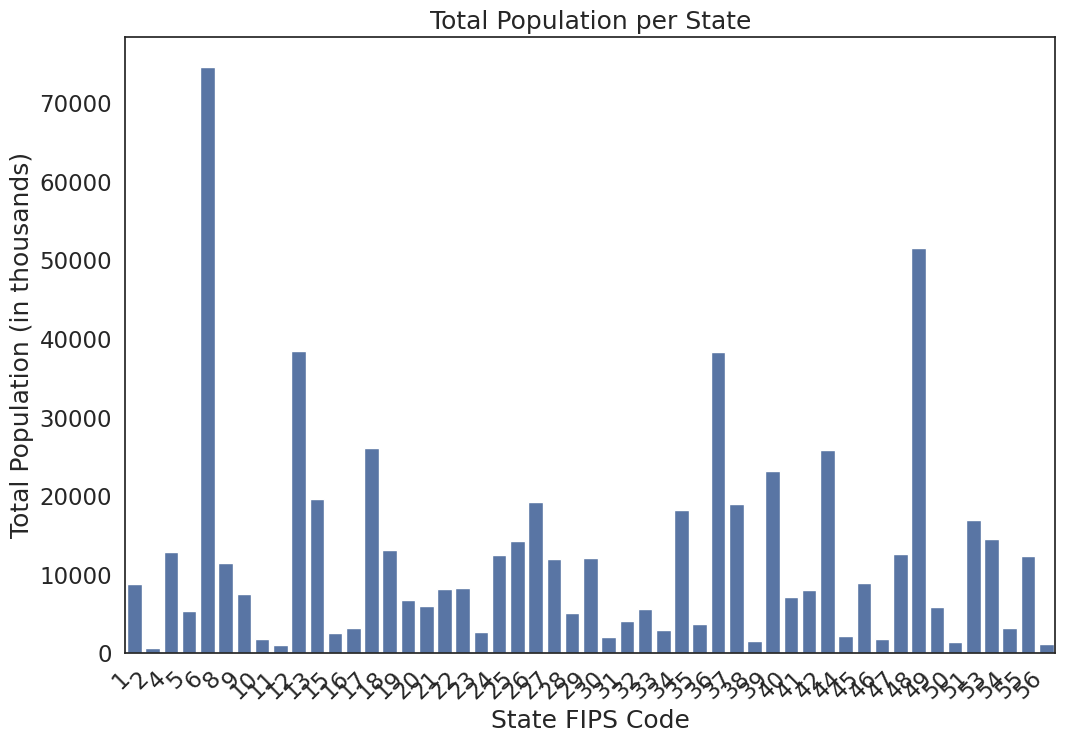

In [17]:
import pandas as pd

# Aggregate population by state for bar plot
state_population = df_c.groupby('state')['population'].sum().reset_index()

sns.barplot(data=state_population, x='state', y='population') # Use barplot to show aggregated population

plt.title('Total Population per State') # add a title
plt.xlabel('State FIPS Code') # change x axis label to reflect FIPS codes

# Adjust x-ticks: since 'state' is a FIPS int, let's just show a few for illustration or remove if there are too many
# For better labeling, you'd ideally merge state names or map FIPS codes to names.
# For now, let's just make sure the existing labels don't cause an error.
# The original xticks line was problematic with 'state' as an int/category.
# Let's try to map some FIPS to names or just remove the specific xticks if too many states.
# For now, let's set simpler labels assuming the FIPS codes are somewhat sequential on the plot.
plt.xticks(rotation=45, ha='right') # Rotate for better readability if many states
plt.ylabel('Total Population (in thousands)')
plt.show() # show the plot

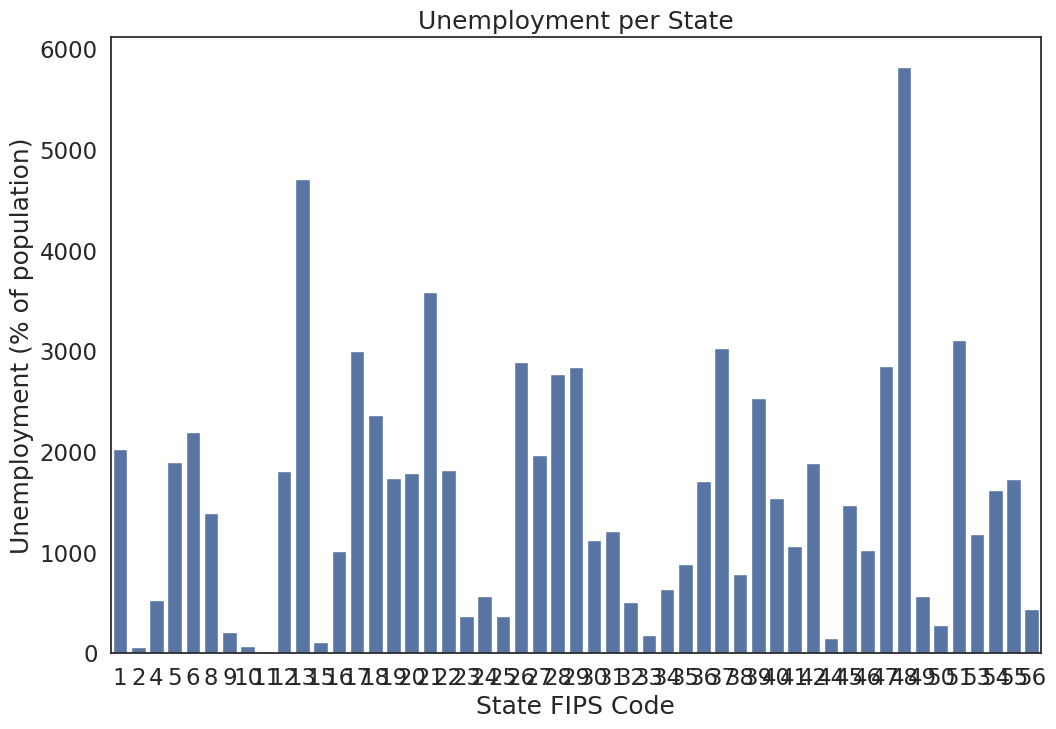

In [19]:
# Aggregate unemployment by state for bar plot
state_unemployment = df_c.groupby('state')['unemployment'].sum().reset_index()

sns.barplot(data=state_unemployment, x='state', y='unemployment') # Use barplot to show aggregated unemplpoyment

plt.title('Unemployment per State') # add a title
plt.xlabel('State FIPS Code') # change x axis label to reflect FIPS codes
plt.ylabel('Unemployment (% of population)')
plt.show() # show the plot

# 3. Assumptions

- A. Independence
- B. Heteroscedasticity: Regression plots + Q-Q plot
- C. Multicollinearity: VIF + Correlation Matrix


INDEPENDENCE: Linear regression assumes that measurements for each sample subject are in no way influenced by or related to the measurements of other subjects.
- this dataset violates the independence assumption because the data is measured over the years. but we will ignore this for now.


HOMOSCEDACITY: Linear regression assumes that the variance of residuals is the same for any value of x, and that residuals are normally distributed with a mean of 0.

- explore this by visually inspecting a regression plot. we are interested in the republican vote share vs unemployment levels; we can plot these variables against eachother using sns.jointplot().

Text(69.75, 0.5, 'Republican Vote share')

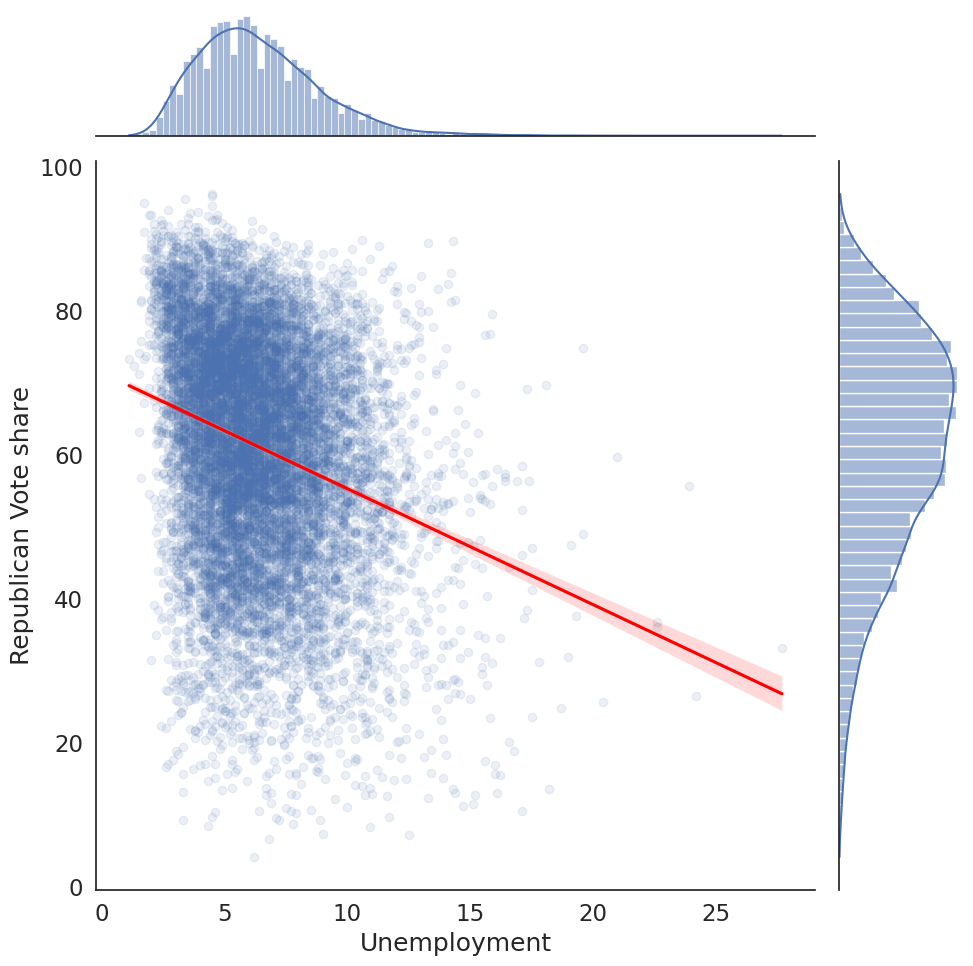

In [20]:
sns.jointplot(data=df_c, # plot a scatterplot with a regression line and two histograms
                x='unemployment', # set the x axis to be unemployment
                y='r_votes', # set the y axis to be the republican vote share
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Unemployment') # add a label to the x axis
plt.ylabel('Republican Vote share') # add a label to the y axis

- republican vote share is relatively normally distributed
- unemployment is heavily right skewed
- this results in heteroscedascity: regression fits the lower values better than the higher values.

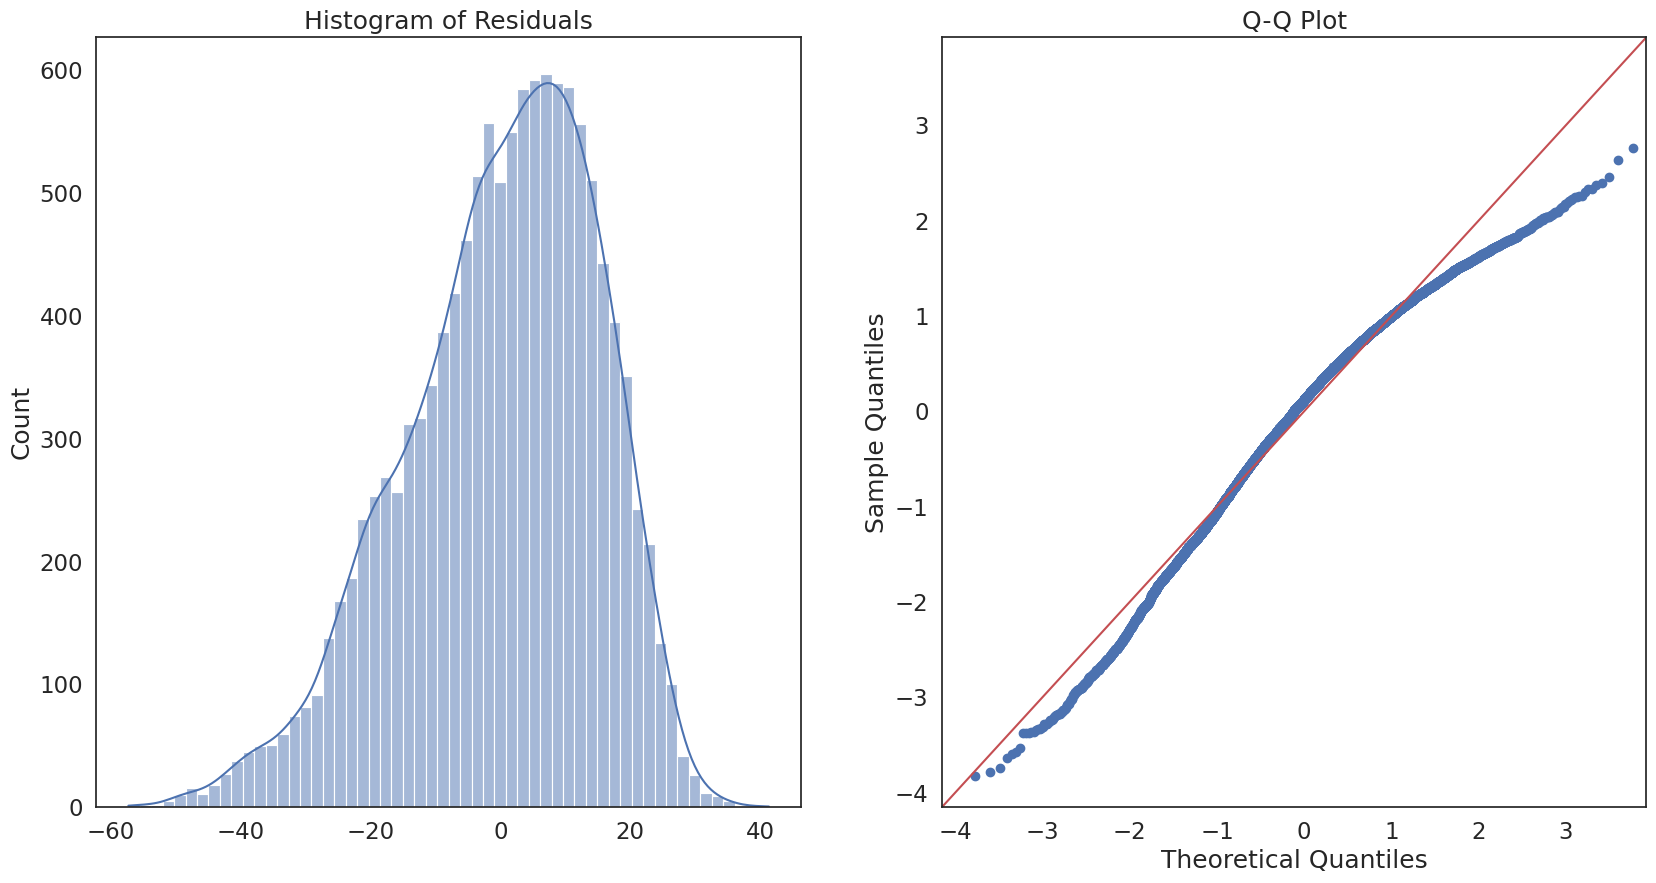

In [23]:
#RUN A Q-Q PLOT

model = ols('r_votes ~  unemployment', data=df_c).fit()  # fit a model
residuals = model.resid # get the residuals

# make the figure wider
plt.rcParams["figure.figsize"] = [20, 10]

f, axes = plt.subplots(1, 2)
sns.histplot(residuals, kde=True, ax=axes[0]) # plot the residuals
axes[0].set_title('Histogram of Residuals') # add a title

sm.qqplot(residuals, line='45', fit=True,  ax=axes[1]) # plot the residuals
axes[1].set_title('Q-Q Plot') # add a title

plt.show() # show the plot

4. Regression
- Regression Table

REGRESSION:
The OLS (ordinary least squares) regressoin seeks to find a straight line that best describes the realtionship between two variables:
$$y= \beta_0 + \beta_1x+\epsilon $$

in our case:

$$Republican\ Voteshare= \beta_0 + \beta_1 \times Unemployment+\epsilon $$


In [25]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

#run the ols regression
model= ols('r_votes ~  unemployment', data=df_c).fit() # fit the model
print(model.summary()) # print the summary

                            OLS Regression Results                            
Dep. Variable:                r_votes   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     878.4
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          1.37e-186
Time:                        15:27:19   Log-Likelihood:                -51386.
No. Observations:               12457   AIC:                         1.028e+05
Df Residuals:                   12455   BIC:                         1.028e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       71.3446      0.372    191.921   

**Interpretation of R-squared:** 0.066
only 6.6% of the variation in republican vote share can be explained by unemployment.

Interpretation of coefficients:
**Intercept**: 71.34
When unemployment = 0, the republican vote share is predicted to be 71%. However, since unemployment never equals 0 in real data, this number is not substantively meaningful.
**unemployment:** -1.60
With each 1% increase in unemployment, republican vote share decreases by 1.61 percentage points, on average. This is statistically significant at p<0.001.



# Cont

In [26]:
models=[] # create empty list to store the models
names=[] # create empty list to store the names of the models
years=df_c['year'].unique()

for year in years: # loop through years from 2000 to 2020 in increments of 4
    election=df_c[df_c['year']==year] # subset the data to only include the year of interest
    model= ols('r_votes ~ unemployment + population', data=election).fit() # run a regression of the republican vote share on the unemployment rate
    models.append(model) # append the model to the list of models
    names.append(str(year)) # append the name of the model to the list of names

table=summary_col( # create a regression table
    models, # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=names, # set the names of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table) # print the table


                  2008      2012      2016      2020  
------------------------------------------------------
Intercept      68.971*** 73.383*** 70.706*** 81.771***
               (0.680)   (0.727)   (0.788)   (0.803)  
unemployment   -1.891*** -1.618*** -1.101*** -2.323***
               (0.109)   (0.088)   (0.142)   (0.115)  
population     -0.023*** -0.024*** -0.034*** -0.029***
               (0.001)   (0.002)   (0.002)   (0.002)  
R-squared      0.148     0.165     0.142     0.229    
R-squared Adj. 0.148     0.165     0.141     0.229    
N              3114      3114      3115      3114     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


This table is pretty informative. Using what we learned from last week, we can say that for the 2020 election,

* A 1% increase in the unemployment rate was associated with a 2.3% *decrease* in republican voteshare.
* A 1000-person increase in population was associated with 0.029% decrease in republican voteshare.
* both of these results are statistically signifiant at the 0.01 level.
* 23% of the variation in republican voteshare can be explained by unemployment and population.

Crucially, "increase" in this context pertains to *differences in between counties*!

We can also compare these results across different elections. The coefficient for the unemployment variable in 2020 is over twice the size of the same coefficient in 2016! So it looks like actually unemployment and republican voteshare are *negatively* related, contrary to popular belief.

But is this the whole story?

Below, i've isolated West Virginia, one of the states with the highest unemployment rates in America. Instead of drawing a new regression line every year, i've drawn a **new regression line for each county over the six elections**.         

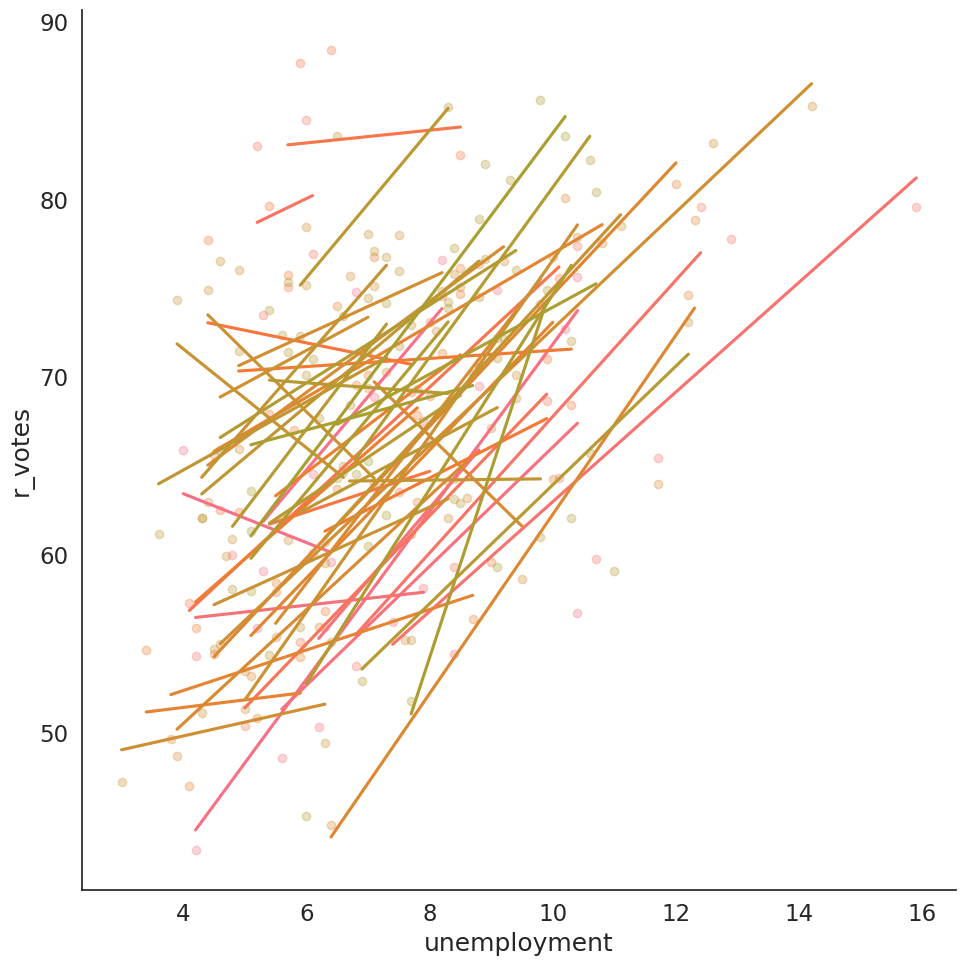

In [27]:
west_virginia=df_c[(df_c['state']==54)]
sns.lmplot(data=west_virginia, x='unemployment', y='r_votes', ci=None, hue='county', height=10, legend=False, palette='husl', scatter_kws={'alpha':.3})

Within a given county, **an increase in the unemployment** rate is associated with an **increase in republican voteshare**! This is where the second question comes in (variation within counties).

We got away with doing a series of cross-sectional analyses (a new regression for each election) because we have over 3000 counties, so $n>3000$ for each of those regressions (though even so, we're still splitting our data up and it would be better to leverage the full dataset of >18000 observations in one regression). It also provides relatively useful information about the importance of unemployment across the country for each election. We can't really apply the same thinking to this situation, since we only have six time periods. If we ran a separate regression for each county, we would only have six observations per regression-- nowhere near enough to satisfy the central limit theorem (at least n>30). The insights would also be of limited utility; we would get over 3000 unique estimates for the realtionship between county-level employment and election results. Imagine trying to fit *that* into one table.

Luckily, there's a way of modeling this relationship that allows us to account for differences in between counties, while also capturing the variation within counties. This is called a **Fixed Effect regression**

> **Fixed Effects Models**: In experimental research, unmeasured differences between subjects are often controlled for via random assignment to treatment and control groups. Hence, even if a variable like Socio-Economic Status is not explicitly measured, because of random assignment, we can be reasonably confident that the effects of SES are approximately equal for all groups. Of course, random assignment is usually not possible with most survey research. If we want to control for the effect of a variable, we must explicitly measure it. If we don’t measure it, we can’t control for it. In practice, there will almost certainly be some variables we have failed to measure (or have measured poorly), so our models will likely suffer from some degree of **omitted variable bias**.
>When we have **panel data** (the same people/states/counties. etc. measured at two or more points in time) another alternative presents itself: we can use the subjects as their own controls. With panel data we can **control for stable characteristics** (i.e. characteristics that do not change across time) whether they are measured or not. These include such things as **sex, race, and ethnicity for individuals**, or **urban/rural, topography, economic structure for geographic areas**. The idea is that, whatever effect these variables have at one point in time, they will have the **same effect** at a different point in time because the values of such variables do not change.

A fixed effect regression takes the following form:

$$\huge Y_{it}=\alpha_i+\beta X_{it}+\epsilon_{it}$$

Where:
* $X_{it}$ are the independent variables (e.g. population and unemployment) whose values vary over time.
* $\beta$ is the slope coefficient for variable $x$ (e.g. unemployment). The model assumes that these effects are time-invariant, e.g. the effect of $x$ is the same at time 1 as it is at time 4 (although the value of $x$ can be different at different time periods).
* $\alpha_i$ and $\epsilon_{it}$ are both error terms. $\epsilon_{it}$ is different for each individual at each point in time. $\alpha_i$ only varies across individuals but not across time. We can think of $\alpha_i$ as representing the effects of all the time invariant/stable variables that have NOT been included in the model. So, given that we have 6 time periods for each county then the six records for county 1 would all have the same value for $\alpha_1$, the six records for county 2 would all have the same value for $\alpha_2$, etc. But, $\epsilon_{it}$ is free to be different for every case at every time period.

A fixed effect regression allows us to account for $\alpha_i$ through a technique called **demeaning**

>**Demeaning**: After demeaning, all variables for all cases have a mean of 0. That means that all the between-subject variability has been eliminated. All that is left is the within-subject variability. So, with a fixed effects model, we are analyzing what causes individual’s values to change across time. Variables whose values do not change (like race or gender) cannot cause changes across time (unless their effects change across time as well). However, whatever effect they have at one time is the same effect that they have at other times, so the effects of such stable characteristics are controlled.

In essence, you can picture this as allowing you to draw a separate regression line through each set of observations from the same group in your data (in this case, one county over time); however, while the *intercept* of these lines can vary (their absolute position), they will all have the same *slope* and will therefore be parallel. This is important, as we want to find one slope-- one common effect of x-- that fits *all* groups.

Run the command below to install the library.

In [28]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.9 MB/s eta 0:00:00


In [40]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.formula.api as smf
from linearmodels.panel import compare

df_c=df_c.set_index(['county_fips','year']) # set the index to the county fips code and the year
panel = PanelOLS.from_formula('r_votes ~ 1  + population + unemployment  + EntityEffects',df_c).fit() # run a fixed effects model
print(compare({'Fixed Effects': panel,}, stars=True)) # print the model formatted as a regression table

           Model Comparison           
                         Fixed Effects
--------------------------------------
Dep. Variable                  r_votes
Estimator                     PanelOLS
No. Observations                 12457
Cov. Est.                   Unadjusted
R-squared                       0.0206
R-Squared (Within)              0.0206
R-Squared (Between)            -0.1061
R-Squared (Overall)            -0.0939
F-statistic                     98.465
P-value (F-stat)                0.0000
=====================     ============
Intercept                    66.818***
                              (159.05)
population                  -0.0727***
                             (-10.241)
unemployment                -0.3268***
                             (-9.3595)
======================= ==============
Effects                         Entity
--------------------------------------

T-stats reported in parentheses


R-squared (Within): 0.0206
The model explains about 2% of the variation in Republican vote share within counties over time. Expected - vote share is very stable within counties from election to electoin.

R-squared (Between): −0.1061
This is negative because fixed effects do not attempt to explain variation between counties (that variation has been subtracted out).
Ignore this value.

R-squared (Overall): −0.0939
This combines within and between variation and often becomes negative in FE models.
Also ignore.



When accounting for time-invariant differences between counties, the effect of population remains negative. This suggests that counties in which the population is *decreasing* tend to experience an increase in republican voteshare. More specifically, for every 1000 people that leave a county, republican voteshare increases by 0.06%.

The really interesting part of this regression table, however, is the **coefficient on the unemployment variable**, which is now **positive**. This suggests that-- once we account for the differences between counties-- an increase in the unemployment rate *within* a county is *positively* associated with republican voteshare. Indeed, a 1% increase in the unemployment rate leads to a 0.28% increase in republican voteshare.

This regression output even gives us three separate $R^2$ values-- one for between-variation, another for within, and one overall.

---------------------------
## 2. Difference in Differences

One of the reasons that we observe a signficant relationship between unemployment and voting behaviour in last week's workshop is that the **Republican and Democratic parties have opposing views on what to do about unemployment**. Democratic lawmakers have historically been in favour of increasing the minimum wage to benefit low-income workers, while Republicans have generally opposed this on the basis that it would hurt these very workers by increase unemployment. Indeed, classical economic theory holds that an increase in wages would lead to a reduction in employment; A business that makes $100k in revenue per year and spends all of it on employing 20 people can't suddenly start paying their workers double their salaries-- unless it fires half of its workers. This is obviously a simplified model though-- minimum wage laws typically don't double wages, and businesses don't operate at-cost, they turn a profit which they could use to pay their workers more. In the rest of this workshop, we're going to be investigating this question empirically:

### Do minimum wage laws increase unemployment?

Note that this is a *causal* question; i'm not asking if they're correlated-- i'm asking if one causes the other. The burden of proof here is much higher than observing correlations, and we have to think seriously about **endogeneity**. In partiuclar, we need to account for the influence of **omitted variables** (e.g. a recession, or the economic composition of a state), the potential for **reverse causality** (states implementing minimum wage laws in response to unemployment crises), and **selection bias**.

In a lab, you can **conduct causal inference** by running an experiment. You can randomly select individuals, split them into a control group and a treatment group, measure their values in an outcome variable prior to a treatment, administer a treatment, and measure their respective values after the treatment. If you observe a change in the outcome variable in the treatment group after having administered the treatment, you can interpert that as the causal effect of treatment. This is because we're able to make a plausible argument that the **control group can act as a counterfactual (a stand-in) for the treatment group in the absence of treatment**. Both groups had the same values before the treatment, then the only thing that changed between them was the treatment, so if we observe a change in the outcome variable, it must be due to treatment.

In the real world, we rarely get to run expermients of this kind. Instead, we have to hunt for **natural experiments**: situations in which there is a **treatment** which we're interested in measuring the effect of, and two groups that can plausibly act as a treatment and control group.

> **[Difference in Difference](https://www.publichealth.columbia.edu/research/population-health-methods/difference-difference-estimation#:~:text=DID%20relies%20on%20a%20less,individual%20level%20is%20not%20possible.)** is a quasi-experimental design that makes use of **longitudinal data** from **treatment** and **control** groups to obtain an appropriate **counterfactual** to estimate a causal effect. DID is typically used to **estimate the effect of a specific intervention or treatment** (such as a passage of law, enactment of policy, or large-scale program implementation) by comparing the changes in outcomes over time between a population that is enrolled in a program (the intervention group) and a population that is not (the control group).

The Difference in Difference model can be estimated as a simple regression model of the following form:

$$\huge Y_{it} = \beta_0 + \beta_1 Treatment_i + \beta_2 Post_t + \beta_3 (Treatment_i \times Post_t) + \varepsilon_{it}$$

- $Treatment_i$ is 0 for the control group and 1 for the treatment group
- $Post_t$ is 0 for before and 1 for after

we can insert the values of $Treatment$ and $Post$ using the table below and see that coefficient ($\beta_3$) of the interaction of $Treatment$ and $Post$ is the Difference in Differences (DID) estimator:

[Card and Krueger (1994)](https://davidcard.berkeley.edu/papers/njmin-aer.pdf) found one such natural experiment, allowing them to estimate the causal effect of an **increase in the state minimum wage on unemployment** using a DiD model; In 1992, New Jersey raised the state minimum wage from \$4.25 to \$5.05 while the minimum wage in neighbouring Pennsylvania stayed the same at \$4.25.
   
* Treatmeng Group: New Jersey
* Control Group: Pennsylvania
* Pre-Treatment Period: before 1992
* Post-Treatment Period: after 1992

They conducted a survey of 384 fast-food restaurants across both states, right before and right after the law came into effect in New Jersey, asking them how many people they employed. They ran a Difference-in-Differences model, and found that the coefficient $\beta_3$ was positive but not statistically significant. In other words, the average total employees per restaurant *increased* after the minimum wage increased, but this could have been due to random chance.

That was a long time ago. Things have changed since then, including the fact that we have access to a lot more data and computational power. Let's see if we can replicate Card and Krueger's results with more recent data. I've downloaded data on unemployment, minimum wage levels, and Gross Domestic Product at the state level going back to 1976. Let's have a look at minimum wages in New Jersey and Pennsylvania over time:

In [30]:
df_s=pd.read_csv('https://storage.googleapis.com/qm2/wk10/state_data.csv', parse_dates=['date']) # read in the state-level data
did=df_s[df_s['state'].isin(['pennsylvania', 'new jersey'])] # subset the data to only include pennsylvania and new jersey

px.line(did, x='date', y='minwage', color='state', title="Minimum Wages in New Jersey and Pennsylvania") # plot the minimum wage over time

The plot above sort of looks like a set of descending staircases; this is for two reasons. The plateaus exist because each row in the dataframe `df_s` is the value of a state in a given *month*, but we only have minimum wage data for every *year*. So we get 12 consecutive values of minimum wage every year. The reason that the staircases are descending is because these minimum wages are adjusted for inflation. No matter where you're from, you've probably heard a grandparent say something along the lines of "My parents would send me to the shops with 25 cents to buy groceries for the week", but now it costs £9 for a bag of chips. That's inflation-- every year things tend to get slightly more expensive, so if the same *absolute* minimum wage actually diminishes in "real" terms, which is what the variable `minwage` measures. Incidentally, this is one of the main reasons University staff have been on [strike](https://www.ucu.org.uk/article/11830/University-staff-pay-cut-by-20-new-figures-show). Anyway. Back to minimum wages.

This plot shows that **for the past fifty years**, New Jersey and Pennsylvania have had **largely similar minimum wage policies**. There have been a couple moments of divergence, including in the 1990s when the Card and Krueger study was conducted. However, the biggest divergence actually started taking place in **2014** when New Jersey seems to have begun taking a wildly different approach. While Pennsylvania has had the same minimum wage since 2008 (and therefore seen a decline in inflation-adjusted wages), **New Jersey has raised the minimum wage significantly twice**. In **2020**, New Jersey's minimum wage was around 50% higher than Pennsylvania's. We can **exploit** the fact that these two states have **historically had similar minimum wage laws** but have recently experienced a big divergence to see if that change in minimum wages has resulted in a change in employment levels.

Our Difference-in-Differences setup is as follows:

$$\large Unemployment_{state, year} = \beta_0 + \beta_1 Treatment_{state} + \beta_2 Post_{year} + \beta_3 (Treatment_{state} \times Post_{year}) + \beta_4 GDP_{state,year} + \varepsilon_{it}$$

* New Jersey is the **treatment group** (1)
* Pennsylvania is the **control group** (0)
* Years before 2014 is the **pre-treatment period** (0)
* Years after 2014 is the **post-treatment period** (1)

In [31]:
did['post']=np.where(did['date']>='2014-01-01',1,0) # create a variable that is 1 if the date is after the minimum wage increase and 0 otherwise
did['treatment']=np.where(did['state']=='new jersey',1,0) # create a variable that is 1 if the state is new jersey (i.e., the treatment group) and 0 for pennsylvania (the control group)
did['post_treatment']=did['post']*did['treatment'] # create a variable that is 1 if the date is after the minimum wage increase and the state is new jersey and 0 otherwise

VARIABLES

post (both states)
- 1 = data **after** the 2014 minimum wage increase
- 0 = data **before** the 2014 minimwm wage increase

treatment (before and after)

- 1 = **New Jersey** (treatment)
- 0 = **Pennsylvania** (control)

post_treatment

- 1 = data for **New Jersey** **after** the 2014 minimum wage increase
- 0 = everything else


Before we proceed with the analysis, though, we need to **satisfy two assumptions** that will allow us to argue that Pennsylvania can act as a valid control group for New Jersey:

1. **No simultaneous treatments:**
    * If, for example, New Jersey suddenly entered a massive recession in 2014 as well, we couldn't really argue that resulting effects on employment are due solely to the minimum wage law. To account for this, we'll be including **state-level GDP** as an **additional independent variable** in our DiD model.

2. **Parallel Trends:**
    * Both states have to have been experiencing **similar trends** in the **dependent variable** (unemployment) **prior to the treatment** (minimum wage law). If they were trending in opposite directions for unobserved reasons, ensuing differences in unemployment may be due to those unobserved reasons rather than the treatment.
    * We can **check this** by **plotting the dependent variable for both groups over time**, and indicating the timing of the treatment.

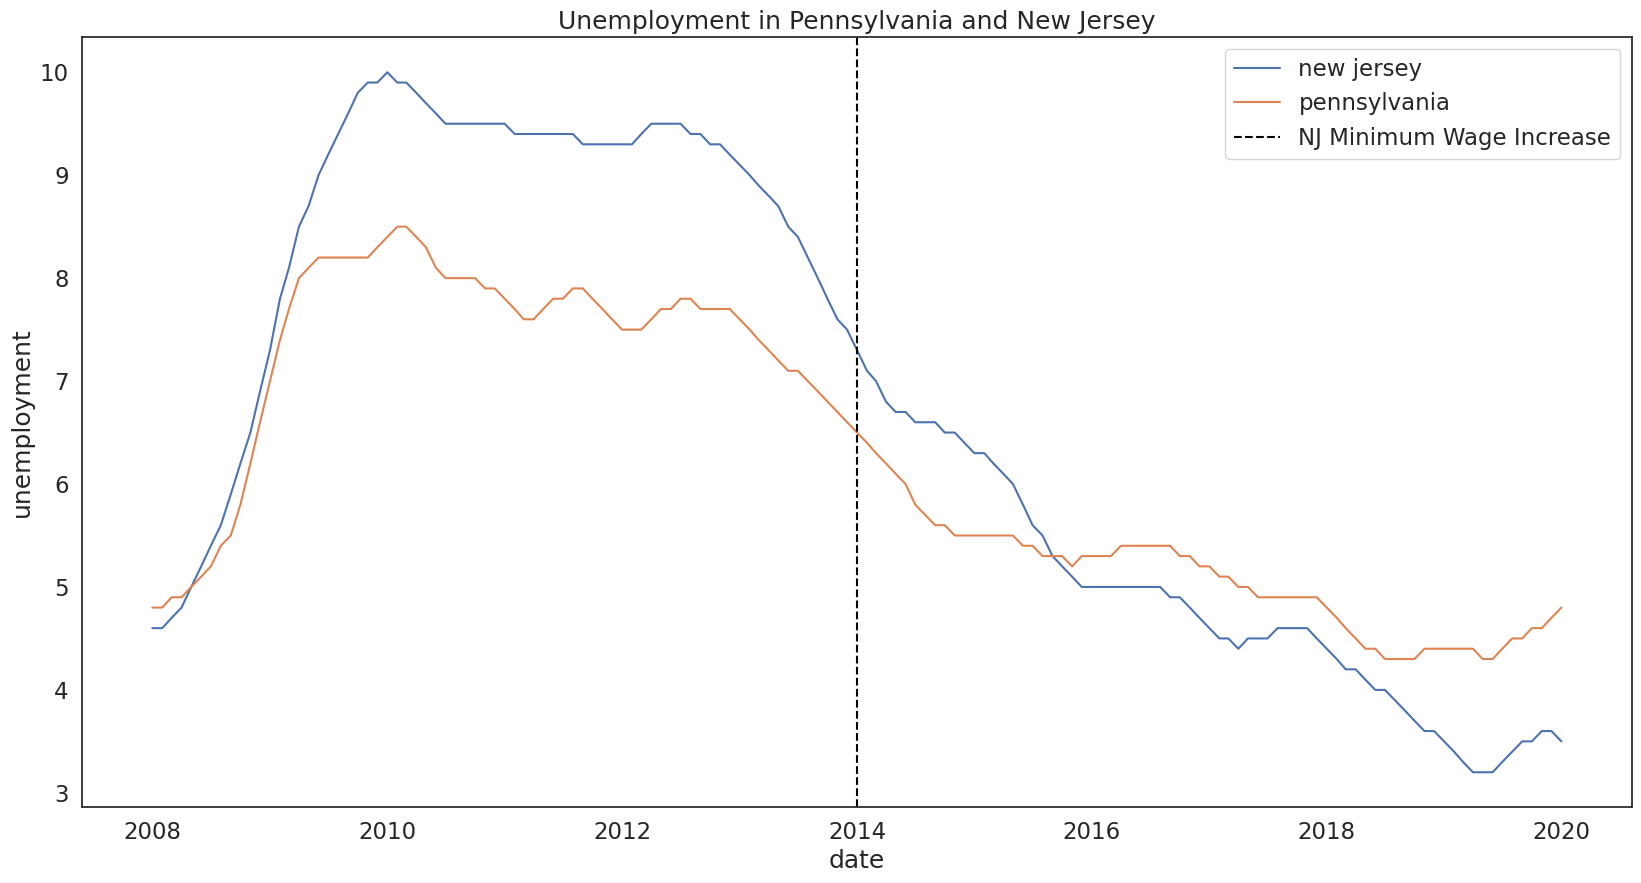

In [32]:
did=did[(did['date']>='2008-01-01') & (did['date']<='2020-01-01')]
sns.lineplot(data=did,x='date',y='unemployment',hue='state')
plt.axvline(pd.to_datetime('2014-01-01'),color='black',linestyle='dashed', label='NJ Minimum Wage Increase')
plt.title('Unemployment in Pennsylvania and New Jersey')
plt.legend()

This plot shows a big **spike** in unemployment occurring for both Pennsylvania and New Jersey as a result of the **2008 financial crisis**. New jersey had a higher unemployment rate than Pennsylvania, but their trends are largely parallel and decreasing after 2012. In the years following the minimum wage law, New Jersey's unemployment rate actually dips below Pennsylvania's for the first time in years. Let's look at this in the form of boxplots:

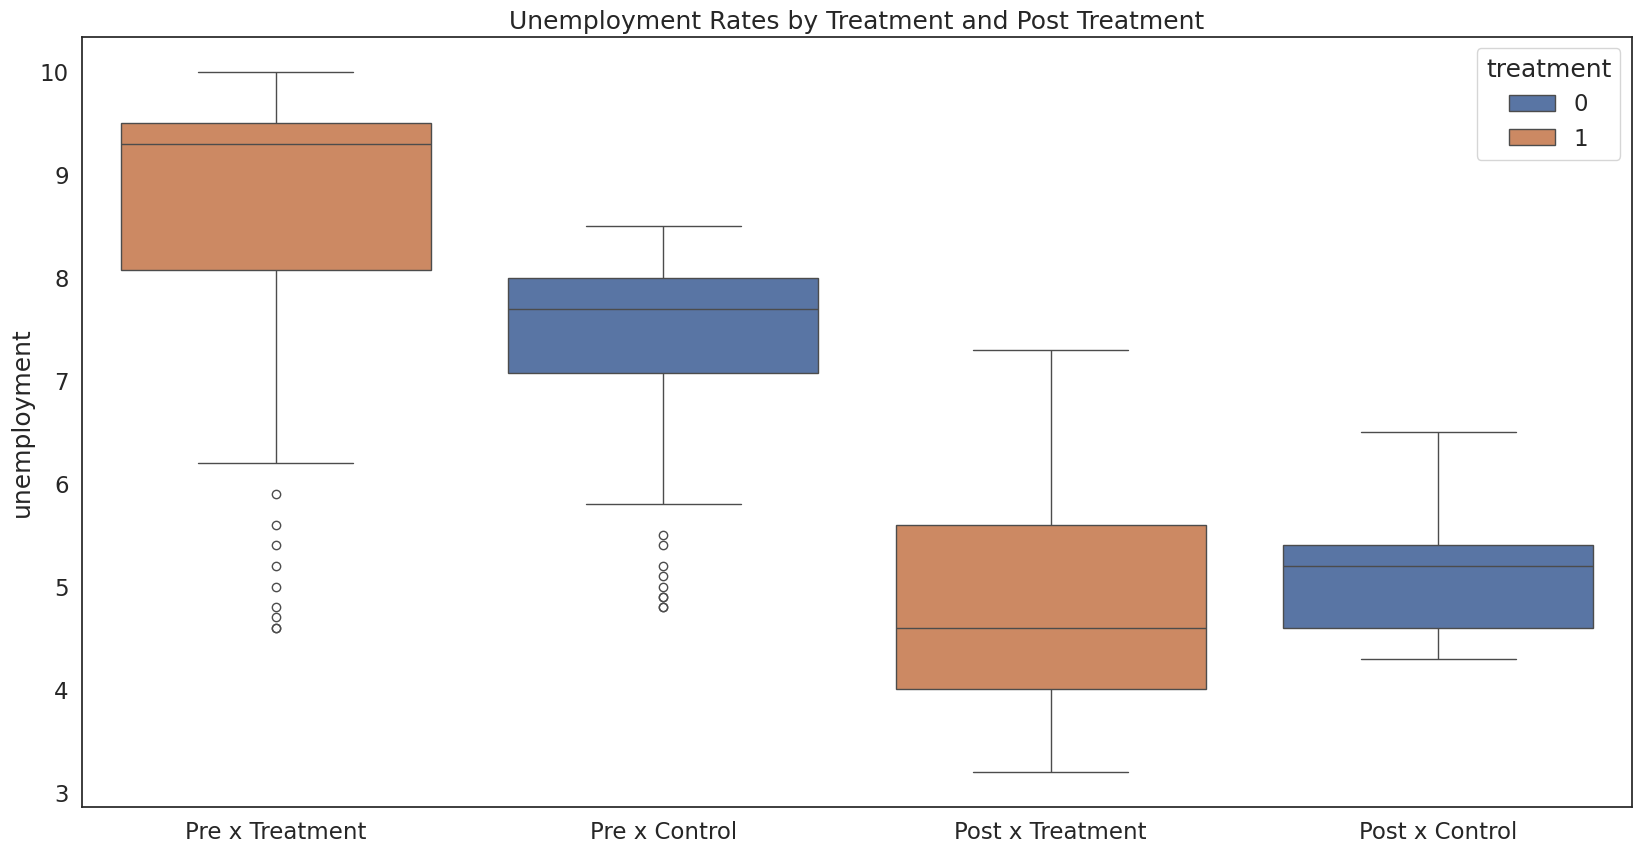

In [33]:
did['category']=did['treatment'].astype(str)+did['post'].astype(str) # this variable is just for the plot below
sns.boxplot(x='category', y='unemployment', hue='treatment', data=did).set_xticklabels(["Pre x Treatment", "Pre x Control",'Post x Treatment','Post x Control'])
plt.xlabel('')
plt.title('Unemployment Rates by Treatment and Post Treatment')
plt.show()

This plot is fascinating in and of itself. The two box plots on the **left** show the unemployment values of the counties **prior** to the minimum wage law in 2014, while the two on the **right** show their values **after** the minimum wage increases.  Pennsylvania (the "control" group) is colored in blue, and New Jersey (the "treatment" group) is colored orange. Prior to the minimum wage increase in 2014, Pennsylvania (blue) has a lower unemployment rate than New Jersey (orange). In the years following New Jersey's passage of the minimum wage law, New Jersey actually has a *lower* unemployment rate than Pennsylvania! This is the only boxplot where the "treatment" (a minimum wage law) is being applied, and it has the lowest unemployment rate.

Let's see if this difference is **statistically signfiicant**, and calculate a treatment effect:

In [34]:
did_model = ols('unemployment ~  post + treatment + post_treatment', did).fit()
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     184.3
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           1.66e-66
Time:                        15:36:25   Log-Likelihood:                -440.98
No. Observations:                 290   AIC:                             890.0
Df Residuals:                     286   BIC:                             904.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.3319      0.131     55.

VARIABLES

**post** = unemployment for both states after the 2014 minimum wage increase

**treatment** = unemployment for New Jersey

**post_treatment** = unemployment for New Jersey after the 2014 minimum wage increase

There are some really interesting results from this model-- let's interpret the coefficients one by one.

* `gdp`: GDP is inversely related to unemployment. This makes sense: GDP basically measures the total amount of economic activity, so more economic activity = more employment.
* `post`: this coefficient is negative, but statistically insignificant at the 0.05 level; it indicates that unemployment *generally* decreased for both groups, but that this could be due to random chance.
* `treatment`: again negative but insignficant, meaning that there is no significant difference in unemployment levels between NJ and PA over the entire period.
* `post_treatment`: this is our difference-in-differences estimator, and reflects the causal effect of treatment. It is negative and statistically significant. If we believe that the asusmptions of our model are satisfied, we can claim that:
    * **The introduction of a minimum wage in New Jersey led to a 1.95% decrease in unemployment relative to Pennsylvania**

This is a bold claim. We should do our best to back it up. Notice that i've sort of arbitrarily chosen a window of dates around the minimum wage law-- maybe this result is a fluke, due to the timespan ive chosen.

To address this concern, I'll **run the same model 10 times**, starting with a really small time window-- just one year on either side of the law-- and progressively expand it.

In [35]:
models=[] # create empty list to store the models
names=[] # create empty list to store the names of the models

for window in range(1,10): # loop through years from 2000 to 2020 in increments of 4
    did=df_s[(df_s['date']>=str(2014-window)+'-01-01') & (df_s['date']<=str(2014+window)+'-01-01') & df_s['state'].isin(['pennsylvania', 'new jersey'])] # subset the data within the window of interest around 2014
    did['post']=np.where(did['date']>='2014-01-01',1,0) # create a dummy variable indicating the period after the minimum wage increase
    did['treatment']=np.where(did['state']=='new jersey',1,0) # create a dummy variable for treatment
    did['post_treatment']=did['post']*did['treatment'] # create an interaction term between the post and treatment variables
    did_model = ols('unemployment ~ gdp+ post + treatment + post_treatment', did).fit() # run the difference in difference model

    models.append(did_model) # append the model to the list of models
    names.append('± '+str(window)+' Year') # append the name of the model to the list of names

table=summary_col( # create a regression table
    models, # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=names, # set the names of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table) # print the table



               ± 1 Year  ± 2 Year  ± 3 Year  ± 4 Year  ± 5 Year  ± 6 Year  ± 7 Year  ± 8 Year  ± 9 Year
-------------------------------------------------------------------------------------------------------
Intercept      21.423** 33.130*** 24.228*** 22.751*** 19.711*** 15.651*** 2.327     -0.580    -2.340*  
               (9.399)  (2.324)   (1.333)   (0.876)   (0.746)   (1.277)   (2.183)   (1.579)   (1.398)  
gdp            -0.000   -0.000*** -0.000*** -0.000*** -0.000*** -0.000*** 0.000**   0.000***  0.000*** 
               (0.000)  (0.000)   (0.000)   (0.000)   (0.000)   (0.000)   (0.000)   (0.000)   (0.000)  
post           -0.619   0.100     -0.262    -0.256*   -0.483*** -0.585*   -2.277*** -2.792*** -3.205***
               (0.411)  (0.194)   (0.162)   (0.140)   (0.154)   (0.307)   (0.576)   (0.501)   (0.479)  
treatment      -1.604   -3.686*** -1.850*** -1.466*** -0.903*** -0.364    1.825***  2.139***  2.241*** 
               (1.896)  (0.479)   (0.285)   (0.190)   (0.169)  

The row we're mainly interested in is the `post_treatment` coefficient, the **treatment effect**. It remains significant and negative in all time periods smaller than 8 years, after which point it becomes insignificant;

How do you think this affects our conclusion?

 The 2014 minimum wage increase in New Jersey is associated with a statistically significant reduction in unemployment in the short-to-medium run (up to about 8 years), relative to Pennsylvania. When using very long time windows (8–10 years), the effect becomes statistically indistinguishable from zero, likely because long-run state differences dominate the data and the parallel trends assumption weakens.



# Assessed Question

1. Find the state with the **largest increase in minimum wage in the 1990s**. This will be our **treatment** group.
2. Set a **5 year window** on either side of the treatment date
3. Make a **parallel trends plot** using **Alabama** as a control group
4. Run a **difference in differences model**.


What was the percentage change in unemployment that resulted from the introduction of a minimum wage in this case? Is the difference statistically significant?

In [41]:
df_s.head()

,fips,state,year,month,population,unemployment,date,code,minwage,fedminwage,cpi,change,gdp
0,1,alabama,1976,1,2605000.0,6.6,1976-01-01,AL,0.00,10.0,56.9,0.00,NaN
1,2,alaska,1976,1,232000.0,7.1,1976-01-01,AK,12.73,10.0,56.9,2.63,NaN
2,4,arizona,1976,1,1621000.0,10.2,1976-01-01,AZ,0.00,10.0,56.9,-2.25,NaN
3,5,arkansas,1976,1,1536000.0,7.3,1976-01-01,AR,8.64,10.0,56.9,2.87,NaN
4,6,california,1976,1,15621000.0,9.2,1976-01-01,CA,9.09,10.0,56.9,1.16,NaN


In [47]:
#filter the dataframe for the years of interest (1990s)
df_90s=df_s[(df_s['date'] >= '1990-01-01') & (df_s['date'] <= '1999-12-31')]
df_90s.head()

,fips,state,year,month,population,unemployment,date,code,minwage,fedminwage,cpi,change,gdp
8904,1,alabama,1990,1,3038768.0,6.7,1990-01-01,AL,0.00,6.63,130.7,0.00,NaN
8905,2,alaska,1990,1,373447.0,7.2,1990-01-01,AK,7.62,6.63,130.7,-0.41,NaN
8906,4,arizona,1990,1,2760367.0,5.0,1990-01-01,AZ,0.00,6.63,130.7,0.00,NaN
8907,5,arkansas,1990,1,1764477.0,6.7,1990-01-01,AR,6.43,6.63,130.7,-0.35,NaN
8908,6,california,1990,1,22570807.0,5.2,1990-01-01,CA,6.63,6.63,130.7,-0.36,NaN


In [60]:
minwage_summary = df_90s.groupby('state')['minwage'].agg(['min', 'max']).reset_index()
minwage_summary['increase'] = minwage_summary['max'] - minwage_summary['min']
largest_increase_state = minwage_summary.loc[minwage_summary['increase'].idxmax()]

print("State with the largest minimum wage increase in the 1990s:")
print(largest_increase_state)


State with the largest minimum wage increase in the 1990s:
state       iowa
min          0.0
max         8.57
increase    8.57
Name: 15, dtype: object


In [49]:
minwage_summary.head()

,state,min,max,increase
0,alabama,0.00,0.00,0.00
1,alaska,7.62,8.97,1.35
2,arizona,0.00,0.00,0.00
3,arkansas,6.36,8.17,1.81
4,california,6.63,8.17,1.54


In [61]:
iowa_minwage=df_90s[df_90s['state']=='iowa']
pd.set_option('display.max_rows', None) # Set option to display all rows
display(iowa_minwage)
pd.reset_option('display.max_rows') # Reset option to default after displaying

,fips,state,year,month,population,unemployment,date,code,minwage,fedminwage,cpi,change,gdp
8920,19,iowa,1990,1,2077928.0,4.4,1990-01-01,IA,0.00,6.63,130.7,0.00,NaN
8973,19,iowa,1990,2,2080050.0,4.4,1990-02-01,IA,0.00,6.63,130.7,0.00,NaN
9026,19,iowa,1990,3,2082172.0,4.3,1990-03-01,IA,0.00,6.63,130.7,0.00,NaN
9079,19,iowa,1990,4,2084000.0,4.3,1990-04-01,IA,0.00,6.63,130.7,0.00,NaN
9132,19,iowa,1990,5,2086641.0,4.3,1990-05-01,IA,0.00,6.63,130.7,0.00,NaN
9185,19,iowa,1990,6,2088969.0,4.4,1990-06-01,IA,0.00,6.63,130.7,0.00,NaN
9238,19,iowa,1990,7,2090297.0,4.4,1990-07-01,IA,0.00,6.63,130.7,0.00,NaN
9291,19,iowa,1990,8,2091625.0,4.4,1990-08-01,IA,0.00,6.63,130.7,0.00,NaN
9344,19,iowa,1990,9,2092953.0,4.5,1990-09-01,IA,0.00,6.63,130.7,0.00,NaN
9397,19,iowa,1990,10,2094281.0,4.6,1990-10-01,IA,0.00,6.63,130.7,0.00,NaN


We can see from this table that a minimum wage law was intoduced in iowa on the 1st of January, 1991.